In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import lightgbm as lgb
import joblib
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import datetime
from tqdm import tqdm
from joblib import Parallel, delayed

In [3]:
items = pd.read_csv("data/input/items.csv")
categories = pd.read_csv("data/input/item_categories.csv")
shops = pd.read_csv("data/input/shops.csv")
train = pd.read_csv("data/input/sales_train.csv")
test = pd.read_csv("data/input/test.csv")

In [4]:
# some statistics of the target
def apply_parallel(dfgroup, func, n_jobs=4, **kwargs):
    results = Parallel(n_jobs=n_jobs)(delayed(func, **kwargs)(group) for name, group in tqdm(dfgroup))
    return pd.concat(results)

def remove_outliers(df):
    q = df["item_cnt_day"].quantile(0.999)
    df = df[(df["item_cnt_day"]>=0) & (df["item_cnt_day"]<=q)]
    df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")
    return df

def get_cartesian_product(train, items):
    shop_list = train["shop_id"].unique()
    item_list = items["item_id"].unique()
    date_block_list = train["date_block_num"].unique()
    prod = pd.DataFrame(list(itertools.product(shop_list, item_list, date_block_list)),
                        columns=["shop_id", "item_id", "date_block_num"])
    return prod

def calc_sales_relate_summary(df):
    if len(df) > 1:
        shop_id = df["shop_id"].values[0]
        item_id = df["item_id"].values[0]
        date_block_num = df["date_block_num"].values[0]
        dates = df["date"].sort_values()
        # ref = dates[0]
        # first_day = datetime.date(ref.year, ref.month, 1)
        # dates = dates.append(first_day).sort_values()
        item_cnt_day = df["item_cnt_day"].values
        prices = df["item_price"].values
        date_intervals = dates.diff(1).dropna().apply(lambda x: x.days)
        # aggregation
        total_sales = item_cnt_day.sum()
        days_with_sales = len(dates)
        avg_sales_per_day = total_sales / days_with_sales
        avg_interval_per_sales = date_intervals.mean()
        avg_price_per_sales = np.average(prices, weights=item_cnt_day)
        data = {"shop_id":shop_id, "item_id":item_id,  "date_block_num": date_block_num,
                "days_with_sales":days_with_sales, "avg_sales_per_day":avg_sales_per_day,
                "avg_interval_per_sales":avg_interval_per_sales, "avg_price_per_sales":avg_price_per_sales}
        return pd.DataFrame(data, index=[0])

def get_month_sales_summary(df):
    return df.groupby(["shop_id", "item_id", "date_block_num"], as_index=False)["item_cnt_day"].\
                                agg({"item_cnt_month":"sum"})

def get_sales_relate_summary(df):
    return apply_parallel(df.groupby(["shop_id", "item_id", "date_block_num"], as_index=False), calc_sales_relate_summary)
    
def get_feature_header(prod, month_summary):
    feature = prod.merge(month_summary, on=["shop_id","item_id","date_block_num"], how="left")
    feature.fillna(0, inplace=True)
    feature = feature[feature["date_block_num"]>11]
    return feature

In [5]:
train = remove_outliers(train)
prod = get_cartesian_product(train, items)
month_sales_summary = get_month_sales_summary(train)
month_sales_relate_summary = get_sales_relate_summary(train)
train_header = get_feature_header(prod, month_sales_summary)
del prod
gc.collect()

C:\Users\DELL\AppData\Local\Temp/ipykernel_6944/3423589298.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y").values
100%|██████████| 1608182/1608182 [06:26<00:00, 4161.10it/s]


0

In [6]:
train_header.to_csv("data/train_header.csv", index=False)
month_sales_summary.to_csv("data/month_sales_summary.csv", index=False)
month_sales_relate_summary.to_csv("data/month_sales_relate_summary.csv", index=False)

## Stage 2

In [7]:
# train_header = pd.read_csv("data/train_header.csv")
# train = remove_outliers(train)
# month_sales_summary = pd.read_csv("data/month_sales_summary.csv")
# month_sales_relate_summary = pd.read_csv("data/month_sales_relate_summary.csv")
# lag features, we produce features of lag defined in lags
def make_lag_feature(df, month_sales_summary, month_sales_relate_summary, lags):
    tmp = df[["shop_id", "item_id", "date_block_num"]]
    for lag in lags:
        tmp["date_block_num"] -= lag
        lag_sales = tmp.merge(month_sales_summary, on=["shop_id", "item_id", "date_block_num"], how="left").fillna(0)
        lag_sales_relate = tmp.merge(month_sales_relate_summary, on=["shop_id", "item_id", "date_block_num"], how="left")
        lag_sales_relate["avg_interval_per_sales"].fillna(9999, inplace=True)
        lag_sales_relate.fillna(0, inplace=True)
        tmp["date_block_num"] += lag
        df["lag"+str(lag)+"_item_cnt"] = lag_sales["item_cnt_month"].values
        relate_cols = lag_sales_relate.columns.difference(tmp.columns)
        for col in relate_cols:
            df["lag"+str(lag)+"_"+col] = lag_sales_relate[col].values
    return df

In [8]:
# mean encoding
def make_rolling_feature(df, summary, lags):
    tmp = df[["shop_id", "item_id", "date_block_num"]]
    for lag in lags:
        lag_features = []
        for i in range(1, lag+1):
            tmp["date_block_num"] -= i
            lag_feature = tmp.merge(summary, on=["shop_id", "item_id", "date_block_num"], how="left").fillna(0)
            lag_features.append(lag_feature["item_cnt_month"].values.reshape(-1, 1)) 
        tmp["date_block_num"] += lag
        lag_features = np.concatenate(lag_features, axis=1)
        avg_weights = [np.exp(-0.2*j) for j in list(range(1, lag+1))]
        lag_avg = np.average(lag_features, axis=1, weights=avg_weights)
        # lag_std = np.std(lag_features, axis=1, ddof=1)
        df["lag"+str(lag)+"_rolling_avg_item_cnt"] = lag_avg
        # df["lag"+str(lag)+"_rolling_std_item_cnt"] = lag_std
    return df

In [9]:
def make_dataset(df, month_sales_summary, month_sales_relate_summary, items):
    print("making lag features")
    df = make_lag_feature(df.copy(), month_sales_summary, month_sales_relate_summary, list(range(1, 13, 1)))
    print("making rolling features")
    df = make_rolling_feature(df.copy(), month_sales_summary, [3, 6, 12])
    df["month_of_year_sin"] = np.sin(df["date_block_num"]/12)
    df["month_of_year_cos"] = np.cos(df["date_block_num"]/12)
    for col in df.iloc[:, 3:].columns:
        df[col] = df[col].astype("float16")
    for col in df.iloc[:, :3].columns:
        df[col] = df[col].astype("int16")
    df = df.merge(items[["item_id", "item_category_id"]], on="item_id")
    df["shop_id"] = df["shop_id"].astype("category")
    df["item_id"] = df["item_id"].astype("category")
    df["item_category_id"] = df["item_category_id"].astype("category")
    return df

In [10]:
feature = make_dataset(train_header, month_sales_summary, month_sales_relate_summary, items)
test["date_block_num"] = 34
feature_test = make_dataset(test, month_sales_summary, month_sales_relate_summary, items)

making lag features


C:\Users\DELL\AppData\Local\Temp/ipykernel_6944/694276064.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["date_block_num"] -= lag
C:\Users\DELL\AppData\Local\Temp/ipykernel_6944/694276064.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["date_block_num"] += lag


making rolling features


MemoryError: Unable to allocate 13.3 GiB for an array with shape (61, 29264400) and data type float64

In [9]:
X_train, X_dev = feature[feature["date_block_num"]<=32].drop(["item_cnt_month", "date_block_num"], axis=1),\
                feature[feature["date_block_num"]>32].drop(["item_cnt_month", "date_block_num"], axis=1)
y_train, y_dev = feature.loc[feature["date_block_num"]<=32, "item_cnt_month"],\
    feature.loc[feature["date_block_num"]>32, "item_cnt_month"]
y_train, y_dev = np.clip(y_train, 0, 20), np.clip(y_dev, 0, 20)
X_test = feature_test.drop("date_block_num", axis=1).iloc[:, 1:]

In [13]:
early_stop = lgb.callback.early_stopping(50)
log_eval = lgb.callback.log_evaluation(5)
model = lgb.LGBMRegressor(num_leaves=15, max_depth=4, learning_rate=0.1, subsample=0.7, colsample_bytree=0.7,
                            min_child_weight=100, reg_alpha=0.8, reg_lambda=0.8, n_estimators=1000)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_dev, y_dev)], eval_metric="rmse", callbacks=[early_stop, log_eval])

C:\Users\DangXuan\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DangXuan\AppData\Roaming\Python\Python37\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\DangXuan\AppData\Roaming\Python\Python37\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 0.484498	valid_0's l2: 0.234738
[2]	valid_0's rmse: 0.480564	valid_0's l2: 0.230941
[3]	valid_0's rmse: 0.476828	valid_0's l2: 0.227365
[4]	valid_0's rmse: 0.473324	valid_0's l2: 0.224036
[5]	valid_0's rmse: 0.470224	valid_0's l2: 0.22111
[6]	valid_0's rmse: 0.467218	valid_0's l2: 0.218293
[7]	valid_0's rmse: 0.464204	valid_0's l2: 0.215486
[8]	valid_0's rmse: 0.461674	valid_0's l2: 0.213143
[9]	valid_0's rmse: 0.459	valid_0's l2: 0.210681
[10]	valid_0's rmse: 0.45675	valid_0's l2: 0.208621
[11]	valid_0's rmse: 0.454352	valid_0's l2: 0.206436
[12]	valid_0's rmse: 0.452176	valid_0's l2: 0.204463
[13]	valid_0's rmse: 0.45002	valid_0's l2: 0.202518
[14]	valid_0's rmse: 0.448244	valid_0's l2: 0.200923
[15]	valid_0's rmse: 0.446314	valid_0's l2: 0.199196
[16]	valid_0's rmse: 0.444593	valid_0's l2: 0.197663
[17]	valid_0's rmse: 0.442895	valid_0's l2: 0.196156
[18]	valid_0's rmse: 0.44128	valid_0's l2: 0.194728
[19]	valid_0's rmse: 0.439907	valid_0's l2: 0.193518
[20]	vali

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.03, max_depth=4,
              min_child_weight=100, n_estimators=500, num_leaves=15,
              reg_alpha=0.5, reg_lambda=0.3, subsample=0.7)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

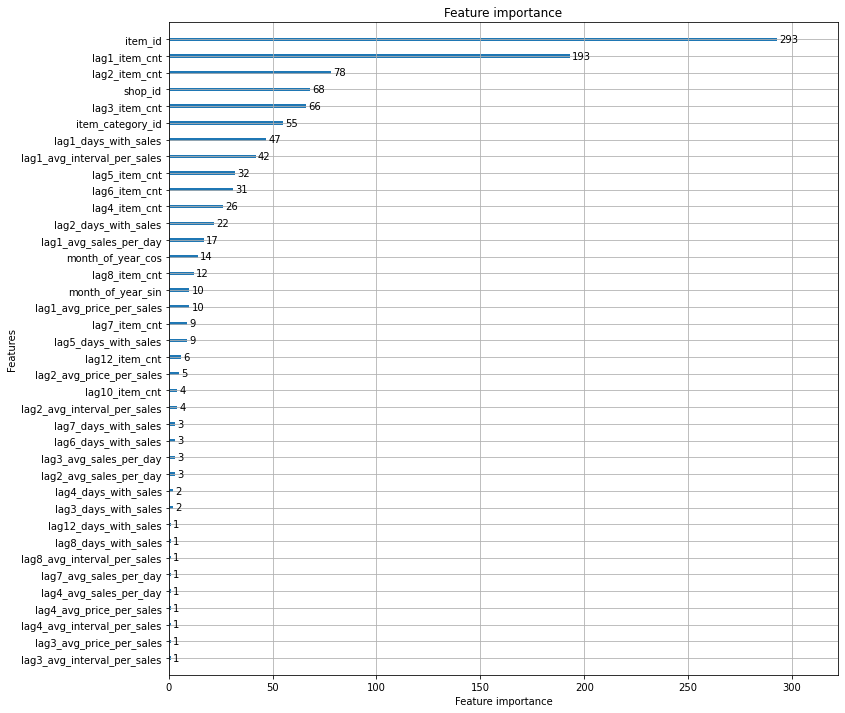

In [14]:
lgb.plot_importance(model, figsize=(12, 12))

In [23]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   shop_id                     214200 non-null  category
 1   item_id                     214200 non-null  category
 2   lag1_item_cnt               214200 non-null  float16 
 3   lag2_item_cnt               214200 non-null  float16 
 4   lag3_item_cnt               214200 non-null  float16 
 5   lag4_item_cnt               214200 non-null  float16 
 6   lag5_item_cnt               214200 non-null  float16 
 7   lag6_item_cnt               214200 non-null  float16 
 8   lag7_item_cnt               214200 non-null  float16 
 9   lag8_item_cnt               214200 non-null  float16 
 10  lag9_item_cnt               214200 non-null  float16 
 11  lag10_item_cnt              214200 non-null  float16 
 12  lag11_item_cnt              214200 non-null  float16 
 13 

In [22]:
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_dev)
print(np.sqrt(mean_squared_error(y_dev, pred_ridge)))

0.4701205183442724


In [30]:
lasso = Lasso(alpha=10)
lasso.fit(X_train, y_train)
pred_lasso = lasso.predict(X_dev)
print(np.sqrt(mean_squared_error(y_dev, pred_lasso)))

0.48877265836334827


In [31]:
rf = RandomForestRegressor(max_depth=5, min_samples_split=100, oob_score=True, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_dev)
print(np.sqrt(mean_squared_error(y_dev, pred_rf)))

0.4206576274295865


In [20]:
pred = model.predict(X_test, num_iteration=model.best_iteration_)
submission = pd.DataFrame({"item_cnt_month":pred}).reset_index().rename({"index":"ID"}, axis=1)
submission.to_csv("data/submission.csv", index=False)

In [108]:
feature.to_csv("data/feature_train_baseline.csv", index=False)
feature_test.to_csv("data/feature_test_baseline.csv", index=False)

In [111]:
joblib.dump(model, "model/lgb_baseline.pkl")

['model/lgb_baseline.pkl']